# KMeans clustering, PCA and data visualization of Well Log Data imported from a LAS

UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.

You can avoid it by setting the environment variable OMP_NUM_THREADS=14.

In [29]:
import os    
os.environ["OMP_NUM_THREADS"] = "14"

## Import Libraries

### Lasio for LAS file data import

In [30]:
import lasio

### Numerical and Plot Libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Use inline, notebook or widget accordingly
#%matplotlib inline

plt.style.use("seaborn-v0_8-talk")

### Import Scikit for Clustering and PCA

In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Read LAS file and create a Pandas dataframe

In [33]:
las = lasio.read("36_7-3.las")
df=las.df()

## Rename a column (well log name)

In [34]:
df.rename(columns={"DEPT":"DEPTH","DTC":"DTCO"}, inplace=True)

## Visualize de dataframe

In [35]:
df

,LITHOLOGY_GEOLINK,CALI,DRHO,NPHI,RHOB,PEF,GR,DTCO,RDEP,RMED
DEPT,,,,,,,,,,
2391.052246,13.0,7.5995,2.602001,0.163522,2.602001,2.602001,60.156601,74.976341,5.1285,3.799290
2391.204590,13.0,7.5995,2.614181,0.154614,2.614181,2.614181,55.742699,75.582024,3.6426,3.531530
2391.357178,13.0,7.5995,2.644800,0.146700,2.644800,2.644800,52.768600,76.907997,2.8279,2.654400
2391.509522,13.0,7.5995,2.622300,0.144200,2.622300,2.622300,55.469299,77.865990,3.0395,2.739600
2391.661865,13.0,7.5995,2.611018,0.143301,2.611018,2.611018,56.582500,78.358215,2.8065,3.330154
...,...,...,...,...,...,...,...,...,...,...
2948.683838,NaN,7.5995,NaN,NaN,NaN,NaN,118.644203,NaN,NaN,NaN
2948.836426,NaN,7.5995,NaN,NaN,NaN,NaN,118.644203,NaN,NaN,NaN
2948.988770,NaN,7.5995,NaN,NaN,NaN,NaN,118.644203,NaN,NaN,NaN


## Create a copy dataframe with a set of logs selected for clustering purpose

In [36]:
# Drop missing data rows
df_clusters = df[["GR", "DTCO", "NPHI", "RHOB"]].dropna()
df_clusters

,GR,DTCO,NPHI,RHOB
DEPT,,,,
2391.052246,60.156601,74.976341,0.163522,2.602001
2391.204590,55.742699,75.582024,0.154614,2.614181
2391.357178,52.768600,76.907997,0.146700,2.644800
2391.509522,55.469299,77.865990,0.144200,2.622300
2391.661865,56.582500,78.358215,0.143301,2.611018
...,...,...,...,...
2923.233154,121.404503,69.192741,0.251400,2.573703
2923.385498,124.444901,68.777664,0.254000,2.571703
2923.537842,126.008499,69.347084,0.269100,2.569004


## Create a metric plot to select an optimal number of clusters

In [37]:
sum_of_sqr_dist = pd.DataFrame({"Clusters": [], "Inertia": []})

for k in range(1,21):
    km=KMeans(n_clusters=k, n_init="auto", init="k-means++", max_iter=300)
    km=km.fit(df_clusters)
    sum_of_sqr_dist.loc[k] = [k,km.inertia_]

sum_of_sqr_dist=sum_of_sqr_dist.astype({"Clusters": int, "Inertia": float})

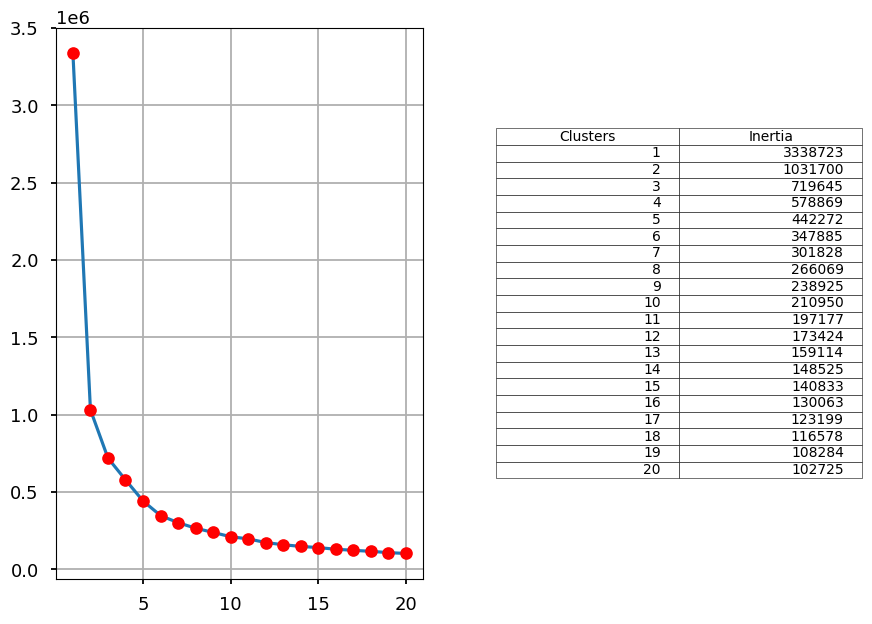

In [38]:
fig, axs = plt.subplots(1,2)

axs[0].plot(sum_of_sqr_dist["Clusters"], sum_of_sqr_dist["Inertia"], marker="o", markerfacecolor="red")
axs[0].grid()

axs[1].axis("tight")
axs[1].axis("off")

axs[1].table(cellText=sum_of_sqr_dist.values.astype(int), colLabels=sum_of_sqr_dist.columns, loc="center")

plt.show()

## Ask the user the cluster number to use forward based on the previous plot

In [39]:
optclust=int(input("In this demo, 5, 8 or 10 cans be used to have demostrative results\n Select optimal number of clusters: \n"))

## Same plot but with a line intersection on the selected cluster number

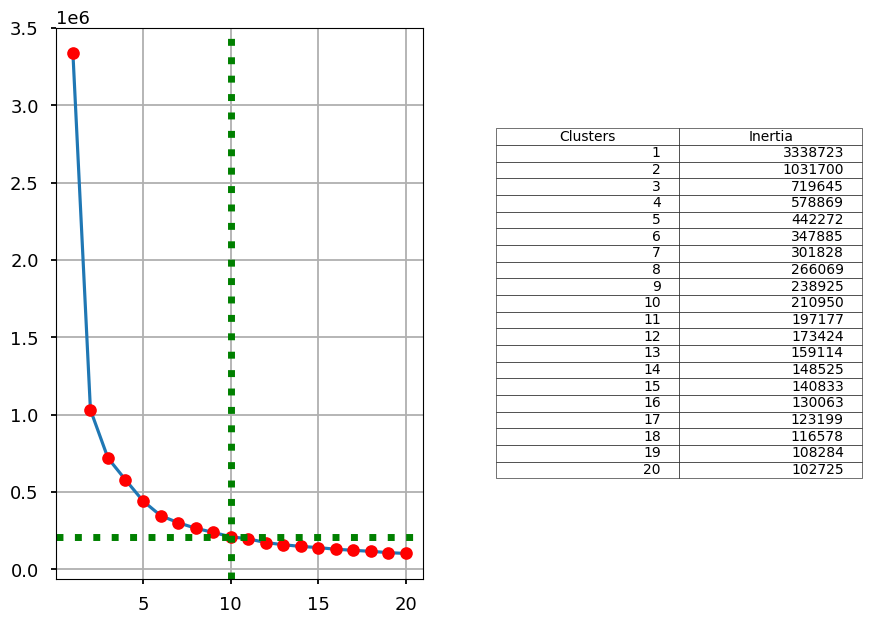

In [40]:
fig, axs = plt.subplots(1,2)

axs[0].plot(sum_of_sqr_dist["Clusters"], sum_of_sqr_dist["Inertia"], marker="o", markerfacecolor="red")
axs[0].grid()

axs[1].axis("tight")
axs[1].axis("off")

axs[1].table(cellText=sum_of_sqr_dist.values.astype(int), colLabels=sum_of_sqr_dist.columns, loc="center")

axs[0].axvline(x=optclust, c="green", ls=":", lw=5)
axs[0].axhline(y=sum_of_sqr_dist["Inertia"][optclust], c="green", ls=":", lw=5)

plt.show()

## Create an initial set of centroids and sort them

In [41]:
km=KMeans(n_clusters=optclust, n_init="auto", init="k-means++", max_iter=300)
km=km.fit(df_clusters)

init_centroids= km.cluster_centers_

#Sort the centroids by the first feature ("GR")
init_centroids = init_centroids[init_centroids[:, 0].argsort()]

## Create KMean model

In [42]:
Model = KMeans(n_clusters=optclust, n_init=1, init=init_centroids, max_iter=300)
Model.fit(df_clusters)

KMeans(init=array([[ 57.80367448,  77.03039343,   0.15686803,   2.61221496],
       [ 59.86624535,  99.27050622,   0.25936435,   2.33632234],
       [ 73.06977988,  94.6413967 ,   0.24542996,   2.45226407],
       [ 76.54110312,  80.93612038,   0.2020449 ,   2.55577608],
       [ 95.2755306 ,  77.21794407,   0.22626781,   2.57898163],
       [ 96.64083488,  94.13604459,   0.24733529,   2.52177104],
       [114.71189152,  76.80171663,   0.25305757,   2.57315077],
       [120.16474335, 101.94626056,   0.29734082,   2.528695  ],
       [130.47085647,  84.65096967,   0.27769317,   2.58808385],
       [144.09876758,  97.25186042,   0.31945739,   2.53968184]]),
       n_clusters=10, n_init=1)

## Create a list of colors for the cluster model based on the optimal number of clusters

In [43]:
cmap = matplotlib.colormaps["rainbow_r"]
norm = matplotlib.colors.Normalize(0, optclust-1)
Color=[]
for i in range(optclust):
    Color.append(cmap(norm(i)))


## Create a table with the clusters coordinates, labels and colors

In [44]:
centroids = Model.cluster_centers_
centroidsDF=pd.DataFrame({"GR": centroids[:,0], "DTCO": centroids[:,1], "NPHI": centroids[:,2], "RHOB": centroids[:,3] })
centroidsDF.sort_values(by=["GR"],inplace=True)
centroidsDF["Cluster"] = Model.predict(centroidsDF)
centroidsDF["Color"] = centroidsDF["Cluster"].map(lambda p:Color[p])

## Predict labels and assign colors to the cluster data frame

In [45]:
df_clusters["Cluster"] = Model.predict(df_clusters)
df_clusters["Color"] = df_clusters["Cluster"].map(lambda p:Color[p])

In [46]:
df_clusters

,GR,DTCO,NPHI,RHOB,Cluster,Color
DEPT,,,,,,
2391.052246,60.156601,74.976341,0.163522,2.602001,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.204590,55.742699,75.582024,0.154614,2.614181,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.357178,52.768600,76.907997,0.146700,2.644800,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.509522,55.469299,77.865990,0.144200,2.622300,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.661865,56.582500,78.358215,0.143301,2.611018,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
...,...,...,...,...,...,...
2923.233154,121.404503,69.192741,0.251400,2.573703,6,"(0.16666666666666674, 0.8660254037844387, 0.86..."
2923.385498,124.444901,68.777664,0.254000,2.571703,6,"(0.16666666666666674, 0.8660254037844387, 0.86..."
2923.537842,126.008499,69.347084,0.269100,2.569004,6,"(0.16666666666666674, 0.8660254037844387, 0.86..."


## Plot the results

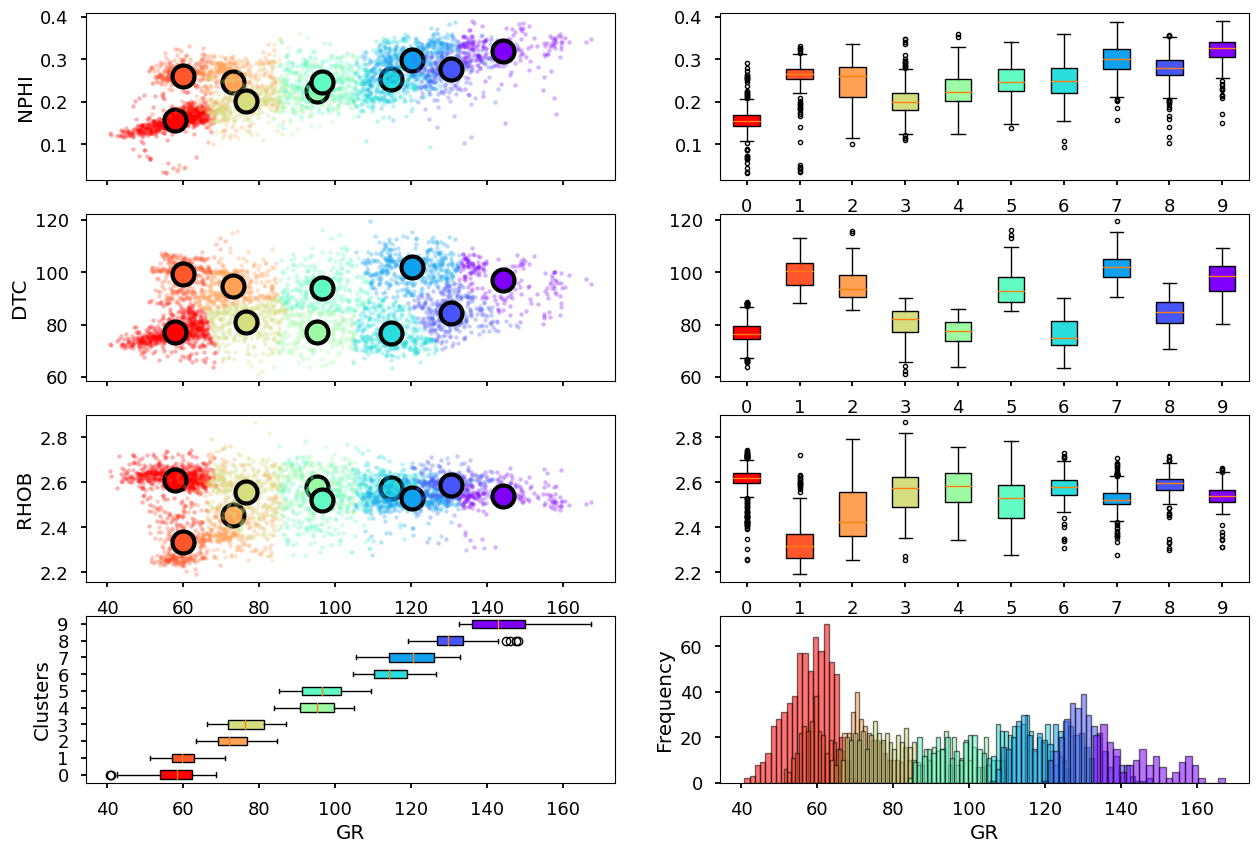

In [63]:
fig, axs = plt.subplots(4,2, figsize=(15,10), sharex=False)

for color in Color:
    axs[0,0].scatter(df_clusters.loc[df_clusters.Color==color]["GR"], df_clusters.loc[df_clusters.Color==color]["NPHI"], color=color, s=10, edgecolor="gray", linewidth=0,alpha=0.3)
    axs[0,0].scatter(centroidsDF.loc[centroidsDF.Color==color]["GR"], centroidsDF.loc[centroidsDF.Color==color]["NPHI"], color=color, s=250, edgecolor="black", linewidth=3, label=str(color))

axs[0,0].set_ylabel("NPHI")
axs[0,0].set_xticklabels([])
                
for color in Color:
    axs[1,0].scatter(df_clusters.loc[df_clusters.Color==color]["GR"], df_clusters.loc[df_clusters.Color==color]["DTCO"], color=color, s=10, edgecolor="gray", linewidth=0,alpha=0.3)
    axs[1,0].scatter(centroidsDF.loc[centroidsDF.Color==color]["GR"], centroidsDF.loc[centroidsDF.Color==color]["DTCO"], color=color, s=250, edgecolor="black", linewidth=3, label=str(color))

axs[1,0].set_ylabel("DTC")
axs[1,0].set_xticklabels([])

for color in Color:
    axs[2,0].scatter(df_clusters.loc[df_clusters.Color==color]["GR"], df_clusters.loc[df_clusters.Color==color]["RHOB"], color=color, s=10, edgecolor="gray", linewidth=0,alpha=0.3)
    axs[2,0].scatter(centroidsDF.loc[centroidsDF.Color==color]["GR"], centroidsDF.loc[centroidsDF.Color==color]["RHOB"], color=color, s=250, edgecolor="black", linewidth=3, label=str(color))                
                
axs[2,0].set_xlabel("GR")
axs[2,0].set_ylabel("RHOB")

boxes=[]
positions=[]
for i in range(0,optclust):
    boxes.append(df_clusters.loc[df_clusters.Cluster==i]["GR"])
    positions.append(i)
bplot = axs[3,0].boxplot(boxes, positions=positions, vert=False, patch_artist=True)
axs[3,0].set_xlabel("GR")
axs[3,0].set_ylabel("Clusters")

for patch, color in zip(bplot['boxes'], Color):
    patch.set_facecolor(color)

boxes=[]
positions=[]
for i in range(0,optclust):
    boxes.append(df_clusters.loc[df_clusters.Cluster==i]["NPHI"])
    positions.append(i)
bplot = axs[0,1].boxplot(boxes, positions=positions, vert=True, patch_artist=True, sym=".")
for patch, color in zip(bplot['boxes'], Color):
    patch.set_facecolor(color)

boxes=[]
positions=[]
for i in range(0,optclust):
    boxes.append(df_clusters.loc[df_clusters.Cluster==i]["DTCO"])
    positions.append(i)
bplot = axs[1,1].boxplot(boxes, positions=positions, vert=True, patch_artist=True, sym=".")
for patch, color in zip(bplot['boxes'], Color):
    patch.set_facecolor(color)

boxes=[]
positions=[]
for i in range(0,optclust):
    boxes.append(df_clusters.loc[df_clusters.Cluster==i]["RHOB"])
    positions.append(i)
bplot = axs[2,1].boxplot(boxes, positions=positions, vert=True, patch_artist=True, sym=".")
for patch, color in zip(bplot['boxes'], Color):
    patch.set_facecolor(color)

             
                
for color in Color:
    axs[3,1].hist(df_clusters.loc[df_clusters.Color==color]["GR"], bins=20, histtype="bar", color=color, alpha=0.55, edgecolor="black", lw=1, label="Muestras: "+ str(color))
                
axs[3, 1].set_xlabel("GR")
axs[3, 1].set_ylabel("Frequency")
                



plt.show()                

## Create PCA model

In [48]:
pca = PCA(n_components=4)

In [49]:
df_cluster_normalized=(df_clusters[["GR","DTCO","NPHI","RHOB"]]-df_clusters[["GR","DTCO","NPHI","RHOB"]].mean())/(df_clusters[["GR","DTCO","NPHI","RHOB"]].std())
X_r = pd.DataFrame(pca.fit(df_cluster_normalized[["GR","DTCO","NPHI","RHOB"]]).transform(df_cluster_normalized[["GR","DTCO","NPHI","RHOB"]]))

In [50]:
X_r = X_r.set_index(df_clusters.index)

In [51]:
X_r["GR"] = df_clusters["GR"]
X_r["DTCO"] = df_clusters["DTCO"]
X_r["NPHI"] = df_clusters["NPHI"]
X_r["RHOB"] = df_clusters["RHOB"]
X_r["Cluster"] = df_clusters["Cluster"]
X_r["Color"] = df_clusters["Color"]
X_r.sort_values(by=["DEPT"],inplace=True)
X_r

,0,1,2,3,GR,DTCO,NPHI,RHOB,Cluster,Color
DEPT,,,,,,,,,,
2391.052246,-1.997172,0.305010,-0.065469,-0.120880,60.156601,74.976341,0.163522,2.602001,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.204590,-2.160690,0.384314,0.095396,-0.145423,55.742699,75.582024,0.154614,2.614181,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.357178,-2.323655,0.336576,0.389548,-0.203054,52.768600,76.907997,0.146700,2.644800,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.509522,-2.182812,0.439365,0.343206,-0.038575,55.469299,77.865990,0.144200,2.622300,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
2391.661865,-2.111455,0.495521,0.320202,0.034829,56.582500,78.358215,0.143301,2.611018,0,"(1.0, 1.2246467991473532e-16, 6.12323399573676..."
...,...,...,...,...,...,...,...,...,...,...
2923.233154,-0.452130,-1.423958,-1.246610,0.207859,121.404503,69.192741,0.251400,2.573703,6,"(0.16666666666666674, 0.8660254037844387, 0.86..."
2923.385498,-0.397225,-1.503115,-1.309420,0.245205,124.444901,68.777664,0.254000,2.571703,6,"(0.16666666666666674, 0.8660254037844387, 0.86..."
2923.537842,-0.187186,-1.564371,-1.356114,0.118296,126.008499,69.347084,0.269100,2.569004,6,"(0.16666666666666674, 0.8660254037844387, 0.86..."


In [52]:
X_r= X_r.reset_index()

In [53]:
tops = pd.read_csv("tops.csv")

In [54]:
tops["DEPTH"]=tops["DEPTH"].astype(float)

## Visualize results

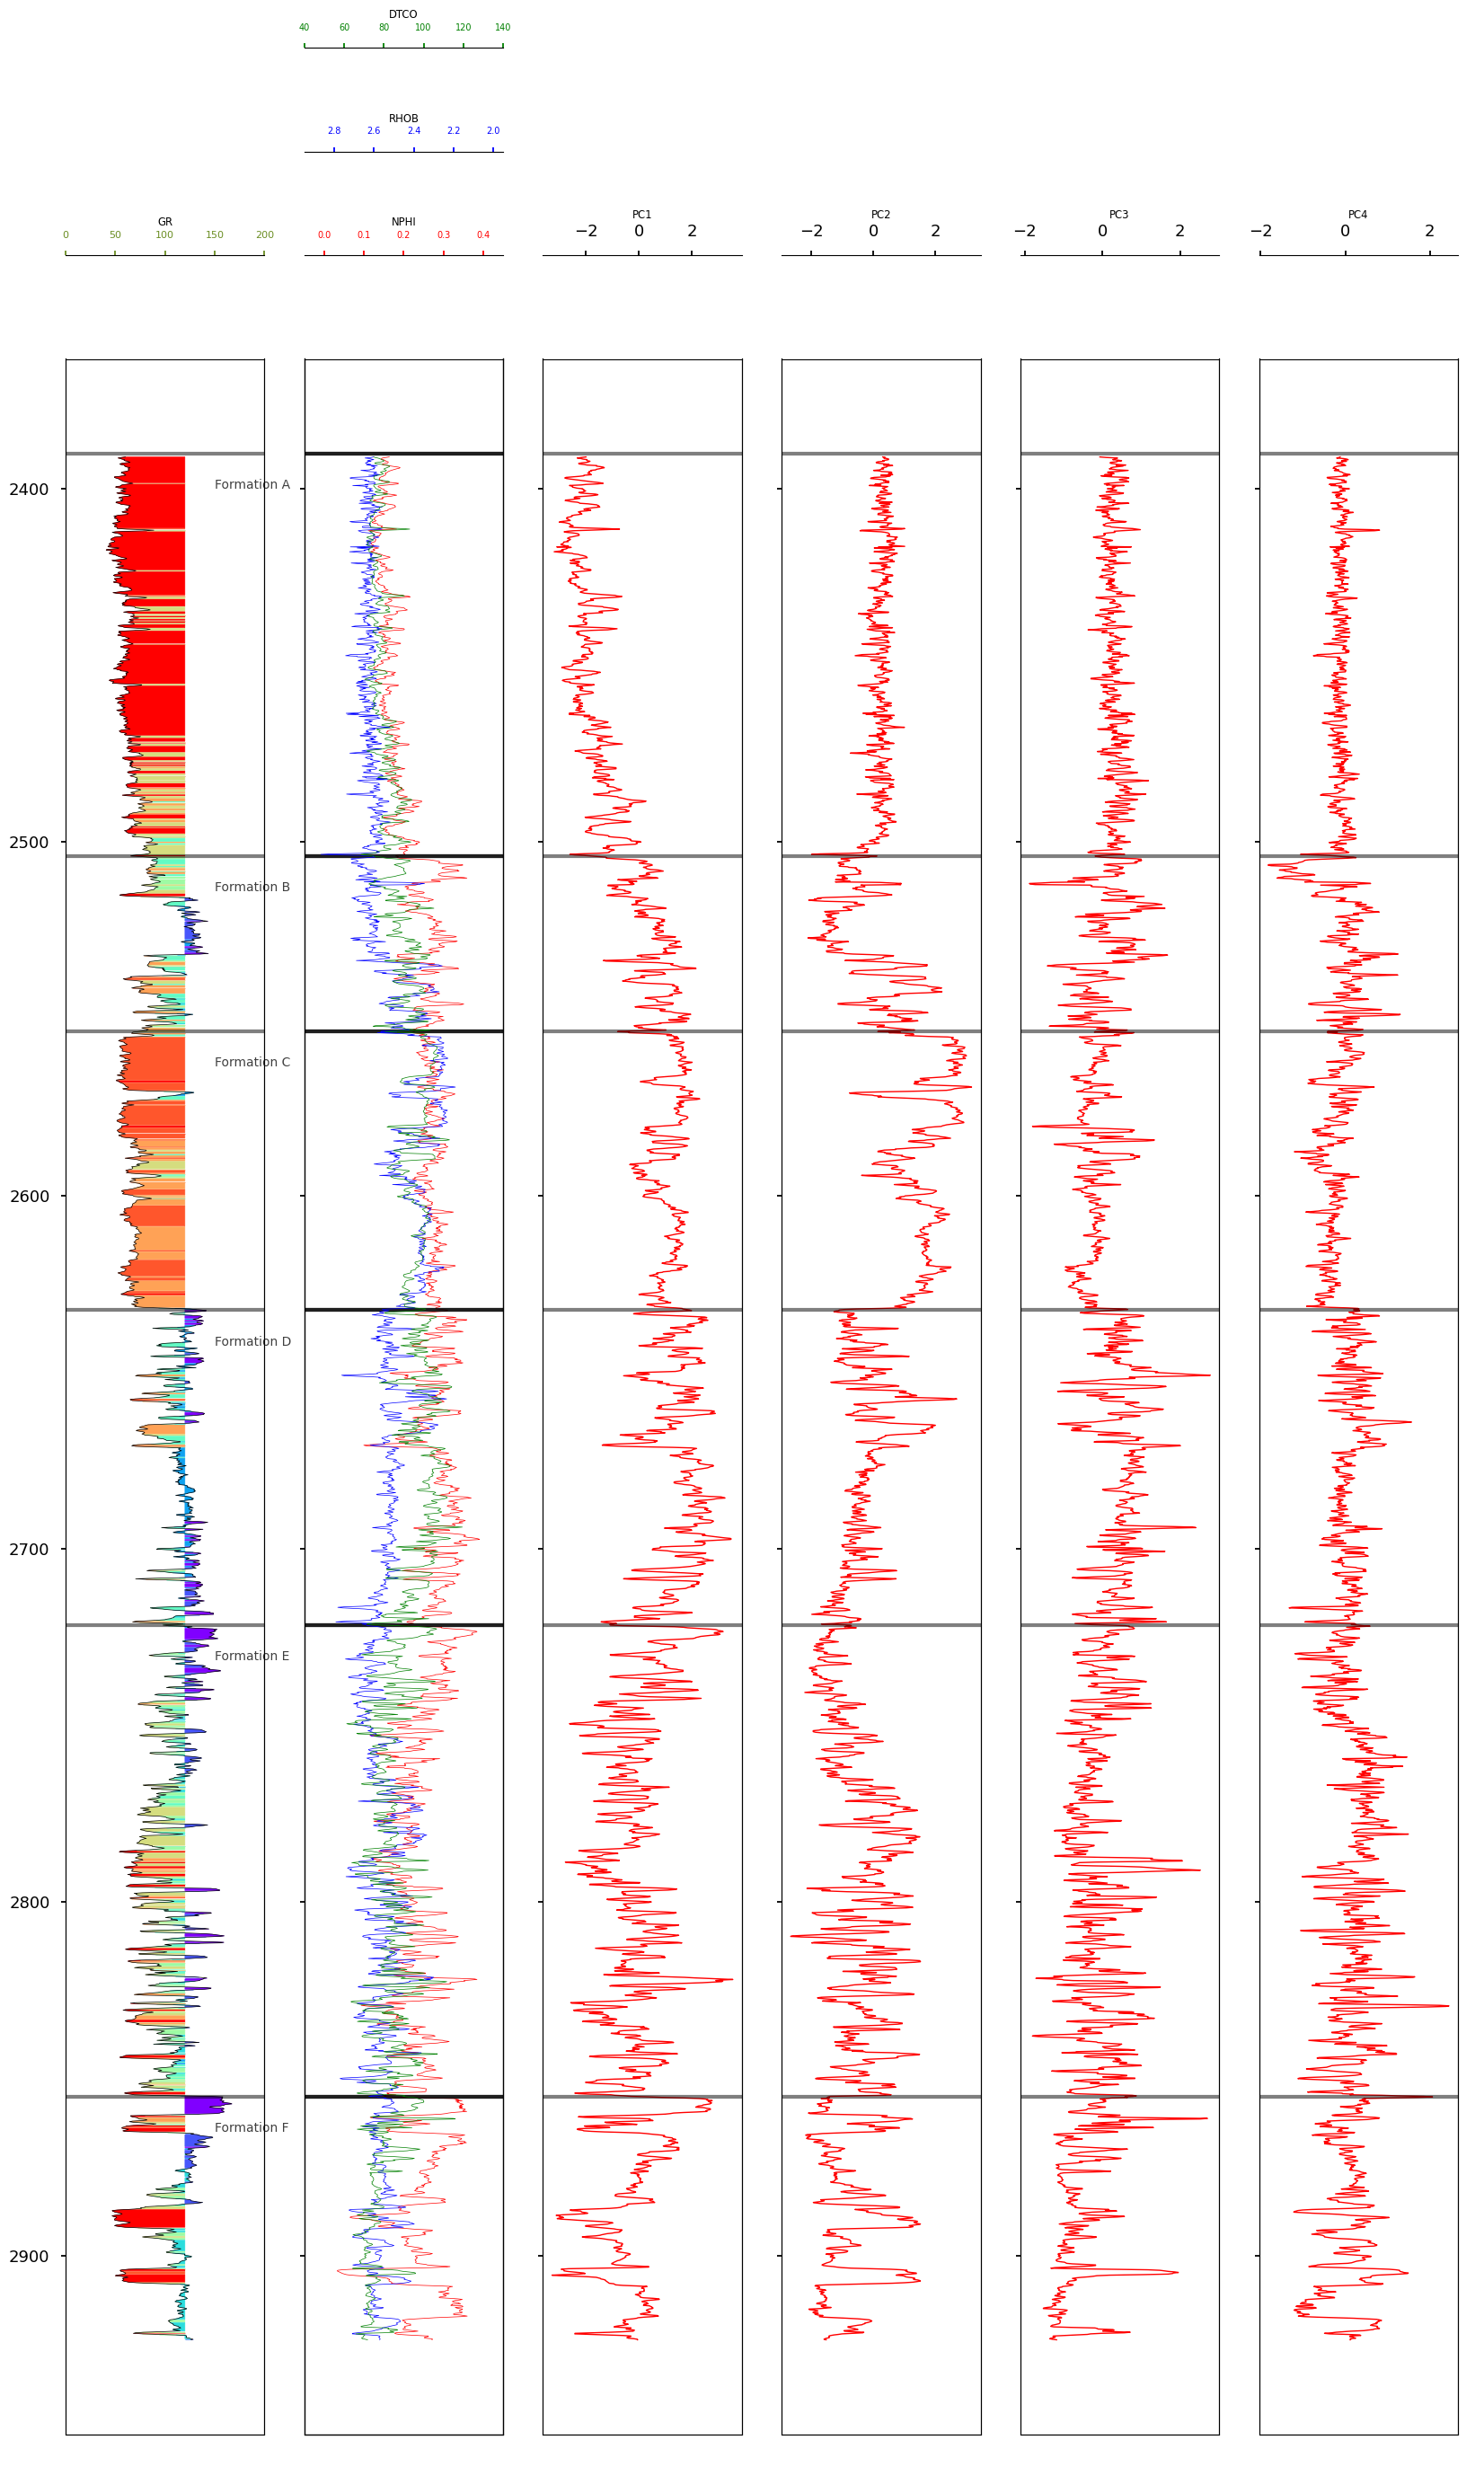

In [55]:
fig, axs = plt.subplots(1,6, sharey=True, figsize=(20,30))

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

axs[0].invert_yaxis()


axs[0].plot()
axs[0].tick_params(axis="x", colors="white")

sa0=axs[0].twiny()

sa0.plot(X_r["GR"],X_r["DEPT"], color="black", linewidth=0.5)
sa0.set_xlim(0,200)
sa0.set_xlabel("GR", fontsize="small")
sa0.tick_params(axis="x", colors="olivedrab", labelsize=8)
sa0.spines.top.set_position(("axes", 1.05))

for color in Color:
    sa0.fill_betweenx(X_r["DEPT"],X_r["GR"],x2=120, where= X_r['Color']==color, color = color)

for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    sa0.annotate(tops["TOPS"][i], xy=(0, d), xytext=(150,d+10), xycoords="data", alpha=0.75, fontsize=10)

axs[1].plot()
axs[1].tick_params(axis="x", colors="white")

sa0=axs[1].twiny()
sa0.plot(X_r["NPHI"],X_r["DEPT"], color="red", linewidth=0.5)
sa0.set_xlim(-0.05,0.45)
sa0.set_xlabel("NPHI", fontsize="small")
sa0.tick_params(axis="x", colors="red", labelsize=7)
sa0.spines.top.set_position(("axes", 1.05))
for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    
sa1=axs[1].twiny()
sa1.plot(X_r["RHOB"],X_r["DEPT"], color="blue", linewidth=0.5)
sa1.set_xlim(2.95,1.95)
sa1.set_xlabel("RHOB", fontsize="small")
sa1.tick_params(axis="x", colors="blue", labelsize=7)
sa1.spines.top.set_position(("axes", 1.1))
for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    
sa2=axs[1].twiny()
sa2.plot(X_r["DTCO"],X_r["DEPT"], color="green", linewidth=0.5)
sa2.set_xlim(40,140)
sa2.set_xlabel("DTCO", fontsize="small")
sa2.tick_params(axis="x", colors="green", labelsize=7)
sa2.spines.top.set_position(("axes", 1.15))
for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    
axs[2].tick_params(axis="x", colors="white")
sa0=axs[2].twiny()
sa0.plot(X_r[0],X_r["DEPT"], c="red", linewidth=1)
sa0.set_xlabel("PC1", fontsize="small")
sa0.spines.top.set_position(("axes", 1.05))
for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    
axs[3].tick_params(axis="x", colors="white")
sa0=axs[3].twiny()
sa0.plot(X_r[1],X_r["DEPT"], c="red", linewidth=1)
sa0.set_xlabel("PC2", fontsize="small")
sa0.spines.top.set_position(("axes", 1.05))
for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    
axs[4].tick_params(axis="x", colors="white")
sa0=axs[4].twiny()
sa0.plot(X_r[2],X_r["DEPT"], c="red", linewidth=1)
sa0.set_xlabel("PC3", fontsize="small")
sa0.spines.top.set_position(("axes", 1.05))
for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    
axs[5].tick_params(axis="x", colors="white")
sa0=axs[5].twiny()
sa0.plot(X_r[3],X_r["DEPT"], c="red", linewidth=1)
sa0.set_xlabel("PC4", fontsize="small")
sa0.spines.top.set_position(("axes", 1.05))
for i, d in enumerate(tops["DEPTH"]):
    sa0.axhline(d, color="black", lw=3, alpha=0.5)
    




plt.show()
fig.savefig("plot.png", dpi=300, format="png")